In [61]:
import numpy as np
import pandas as pd 
import pickle as p
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
#import depth_predictor as dp
from toolbox import lidar_predictor as lp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Trainig data

In [62]:
dataset1 = '/home/dlrc1/Documents/cheesecake/RobotMapping/demo/RobotAppleRight_LidarData/alltrajectories.p'
dataset2 = '/home/dlrc1/Documents/cheesecake/RobotMapping/demo/RobotPanning_overapple/alltrajectories.p'

In [63]:
data = p.load(open(dataset1, 'rb'))
data.columns

Index(['timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos',
       'timestamp_lidar', 'lidar_data'],
      dtype='object')

In [64]:
original_joints = np.array(list(data['joint_pos'].values))
original_lidars = np.array(list(data['lidar_data'].values))

In [65]:
data2 = p.load(open(dataset2, 'rb'))
data.columns

Index(['timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos',
       'timestamp_lidar', 'lidar_data'],
      dtype='object')

In [66]:
original_joints2 = np.array(list(data2['joint_pos'].values))
original_lidars2 = np.array(list(data2['lidar_data'].values))


In [67]:
joints = np.concatenate((original_joints, original_joints2))
lidars = np.concatenate((original_lidars, original_lidars2))


## Create & Train Classifier Objects

In [70]:
lidar_binning_params = {'max_value':1, 'bin_lenght':0.01 }
lidar_training_data={'joints':joints, 'lidar_data':lidars, 'epochs':5000, 
                     'binning_params':lidar_binning_params, 'model_name':'model_lidar_new'}
lidar_predictor = lp.lidar_predictor(binning_params=lidar_binning_params, train=True, training_data=lidar_training_data)

# load prexisting models via: 
#lidar_predictor = lp.lidar_predictor(binning_params=lidar_binning_params, 
#                                     model_names=['model_lidar_new{}.h5'.format(i) for i in range(9)], train=False)

1.7.0

training lidar 0


TypeError: super(type, obj): obj must be an instance or subtype of type

depth_training_data={'joints':original_joints, 'depth_images':original_depth, 'epochs':5000}
depth_predictor = dp.depth_predictor(model_name='depth_predictor.h5', train=True, training_data=depth_training_data)


## Test prediction on new dataset

In [20]:
test_data = p.load(open('data/scan_desk_10_10_2_box.p', 'rb'))
test_joints = np.array(list(test_data['joint_pos'].values))
test_lidars = np.array(list(test_data['lidar_data'].values))
test_depth = np.array(list(test_data['depth_img'].values))


In [21]:
print(len(test_lidars))

31


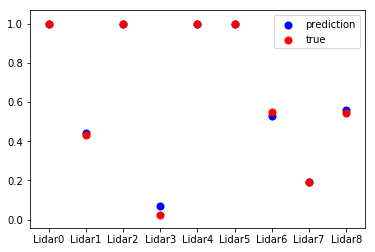

In [22]:
idx = 7
prediction = lidar_predictor.predict_single(joint_data=test_joints[idx, :], true_lidar=test_lidars[idx, :], plot = True)

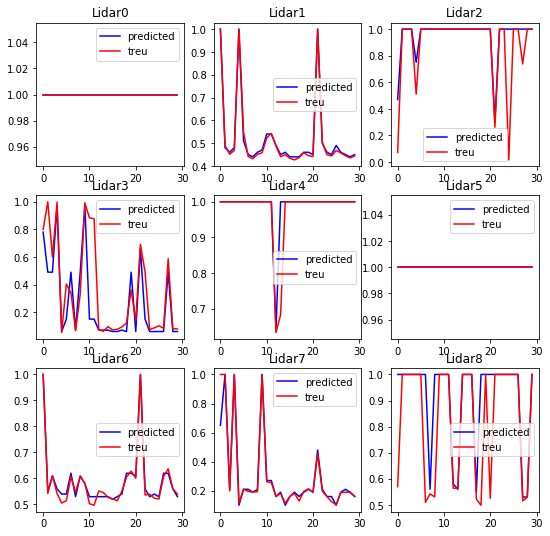

In [23]:
idx = 30
lid = lidar_predictor.predict_timeseries(joint_data=test_joints[:idx, :], true_lidar=test_lidars[:idx, :], plot = True)

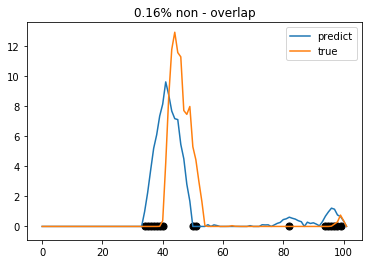

KeyboardInterrupt: 

In [30]:
for idx in range(30): 
    depth_predictor.predict_single(joints_raw=test_joints[idx,:], depth_img_raw=test_depth[idx, :])
    time.sleep(0.5)
    clear_output()
    

In [59]:
def detect_anomalie(prediction, measurement, threshold): 
    # dim prediction = timestamps x lidars
    
    error = measurement - prediction # positive error means something is closer than expected
    med_error = np.median(error, axis = 0) # calculate median over timestamps will ignore negantive and small values 
    
    if (med_error>threshold).any():
        print('Deviation of {} in liadar {}.'.format(np.round(np.max(med_error), 2), np.argmax(med_error)))
        print(med_error)
        return True 
    else: 
        return False 

In [60]:
guess, correct = lidar_predictor.predict_timeseries(joint_data=test_joints[5:10, :], true_lidar=test_lidars[5:10, :], plot = False)

In [62]:
guess

array([[1.  , 0.51, 1.  , 0.15, 1.  , 1.  , 0.54, 0.21, 1.  ],
       [1.  , 0.45, 1.  , 0.49, 1.  , 1.  , 0.62, 0.21, 1.  ],
       [1.  , 0.44, 1.  , 0.07, 1.  , 1.  , 0.53, 0.19, 0.56],
       [1.  , 0.46, 1.  , 0.49, 1.  , 1.  , 0.61, 0.21, 1.  ],
       [1.  , 0.47, 1.  , 0.97, 1.  , 1.  , 0.58, 1.  , 1.  ]])

In [63]:
correct

array([[1.        , 1.        , 1.        , 0.40711462, 1.        ,
        1.        , 0.84691358, 0.2105    , 1.        ],
       [1.        , 0.80565693, 1.        , 0.34519104, 1.        ,
        1.        , 0.99835391, 0.195     , 0.5095    ],
       [1.        , 0.78740876, 1.        , 0.06719368, 1.        ,
        1.        , 0.89958848, 0.191     , 0.542     ],
       [1.        , 0.8229927 , 1.        , 0.33201581, 1.        ,
        1.        , 1.        , 0.1935    , 0.5305    ],
       [1.        , 0.83576642, 1.        , 1.        , 1.        ,
        1.        , 0.95802469, 1.        , 1.        ]])

In [61]:
detect_anomalie(guess, correct, 0)

(5, 9)
Deviation of 0.38 in liadar 6.
[ 0.          0.3629927   0.         -0.00280632  0.          0.
  0.37802469  0.         -0.018     ]


True

In [56]:
from collections import Counter
def depth_image_preprocessing(images, res = 0.01): 
    '''Inputs: 
    images........... a np.array conataining depth measurements of size samples x pixels
    
    Takes an array of depth measurements (usually between 0 and 8000 mm), 
    normalizes them to lie between 0 and 1 and creates a probability distribution od the 
    normalized values by sorting them to bins of withd 0.01. The resulting distribution 
    is normalized to sum to 100.'''
    
    Nimgs = images.shape[0]
    bins = np.arange(0, 1+2*res, res)
    processed_imgs = np.zeros((Nimgs, len(bins)))
    
    for idx in range(Nimgs): 
        img_array = images[idx, :]
        processed_img = img_array
        processed_img = processed_img/np.max(processed_img)        
        ranges = np.digitize(processed_img, bins)
        count = Counter(ranges)
        img_distr = np.zeros(len(bins))
        img_distr[np.array(list(count.keys()))] = np.array(list(count.values()))
        img_distr = (img_distr/np.sum(img_distr))*100
        processed_imgs[idx, :] = img_distr
        
    return processed_imgs

In [41]:
predicted = depth_predictor.predict_timeseries(joints_raw=test_joints, depth_img_raw=test_depth, plot=False)
preprocessed = depth_image_preprocessing(test_depth)

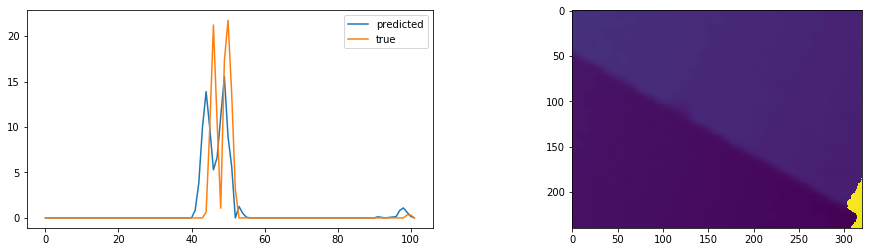

In [49]:
for i in range(31): 
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1,2,1)
    plt.plot(predicted[i, :], label='predicted')
    plt.plot(preprocessed[i, :], label='true')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(test_depth[i, :], (240, 320)))
    plt.show()
    
    time.sleep(2)
    clear_output(wait=True)